**LBB - Causal Inference for Business Decisions: Understanding Cause and Effect**
- Developed by Heinz Metrosan Donradt S

# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import causaldata 
from causalgraphicalmodels import CausalGraphicalModel
import warnings
warnings.simplefilter("ignore", FutureWarning)

## Definisikan tujuan dan hipotesis kausal

**Tujuan**: Menganalisis dampak parental involvement law (variabel pi) terhadap angka kejadian tertentu seperti tingkat penyakit menular seksual, angka kematian AIDS, atau indikator sosial lainnya.

**Hipotesis Kausal**: Adanya parental involvement law (pi) menurunkan angka kematian AIDS (acc) di kalangan remaja usia 15-19 tahun, atau mempengaruhi indikator kesehatan/sosial lainnya.

## Melakukan load data dan exploratory data analysis

In [2]:
abortion = causaldata.abortion.load_pandas().data
abortion.head()

,fip,age,race,year,sex,totpop,ir,crack,alcohol,income,...,repeal,acc,wht,male,lnr,t,younger,fa,pi,bf15
0,1,30,2,1985,1,78805,371.475800,0.217438,1.9,11566.0,...,0,0.679504,0,1,7.880880,1,0,NaN,0,0
1,1,15,1,1985,2,224003,51.389252,0.217438,1.9,11566.0,...,0,0.679504,1,0,6.362165,1,1,1.0,0,0
2,1,20,2,1985,2,94113,390.875671,0.217438,1.9,11566.0,...,0,0.679504,0,0,8.917793,1,0,NaN,0,0
3,1,20,1,1985,1,252076,100.836800,0.217438,1.9,11566.0,...,0,0.679504,1,1,5.906995,1,0,NaN,0,0
4,1,20,2,1985,1,94113,390.875671,0.217438,1.9,11566.0,...,0,0.679504,0,1,9.072009,1,0,NaN,0,0


In [3]:
print(causaldata.abortion.NOTE)
print("-------")
print(causaldata.abortion.DESCRLONG)
print("-------")
print(causaldata.abortion.SOURCE)

::
    Number of observations - 19584
    Number of variables - 22
    Variables name definitions::
            fip - State FIPS code
            age - Age in years
            race - Race: 1 = white, 2 = black
            year - Year
            t - Year but on a different scale
            sex - Sex: 1 = male, 2 = female
            totpop - Total population
            ir - Incarcerated Males per 100,000
            crack - Crack index
            alcohol - Alcohol consumption per capita
            income - Real income per capita
            ur - State unemployment rate
            poverty - Poverty rate
            repeal - In a state with an early repeal of abortion prohibition
            acc - AIDS mortality per 100,000 cumulative in t, t-1, t-2, t-3
            wht - White Indicator
            male - Male Indicator
            lnr - Logged gonnorhea cases per 100,000 in 15-19 year olds
            younger - From the younger group
            fa - State-younger interaction
   

In [4]:
abortion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19584 entries, 0 to 19583
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   fip      19584 non-null  int8    
 1   age      19584 non-null  category
 2   race     19584 non-null  int8    
 3   year     19584 non-null  int16   
 4   sex      19584 non-null  int8    
 5   totpop   19584 non-null  int32   
 6   ir       19584 non-null  float32 
 7   crack    19584 non-null  float32 
 8   alcohol  19584 non-null  float32 
 9   income   19584 non-null  float32 
 10  ur       19584 non-null  float32 
 11  poverty  19584 non-null  float32 
 12  repeal   19584 non-null  int8    
 13  acc      19584 non-null  float32 
 14  wht      19584 non-null  int8    
 15  male     19584 non-null  int8    
 16  lnr      17921 non-null  float32 
 17  t        19584 non-null  int8    
 18  younger  19584 non-null  int8    
 19  fa       6528 non-null   float64 
 20  pi       19584 non-null  int

In [5]:
abortion['age'] = pd.to_numeric(abortion['age'], errors='coerce')

In [6]:
abortion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19584 entries, 0 to 19583
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fip      19584 non-null  int8   
 1   age      19584 non-null  int64  
 2   race     19584 non-null  int8   
 3   year     19584 non-null  int16  
 4   sex      19584 non-null  int8   
 5   totpop   19584 non-null  int32  
 6   ir       19584 non-null  float32
 7   crack    19584 non-null  float32
 8   alcohol  19584 non-null  float32
 9   income   19584 non-null  float32
 10  ur       19584 non-null  float32
 11  poverty  19584 non-null  float32
 12  repeal   19584 non-null  int8   
 13  acc      19584 non-null  float32
 14  wht      19584 non-null  int8   
 15  male     19584 non-null  int8   
 16  lnr      17921 non-null  float32
 17  t        19584 non-null  int8   
 18  younger  19584 non-null  int8   
 19  fa       6528 non-null   float64
 20  pi       19584 non-null  int8   
 21  bf15     195

## Membuat causal diagram

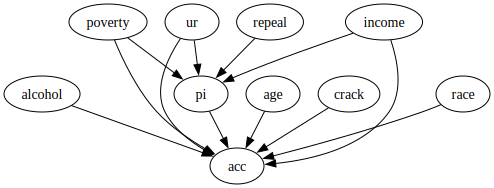

In [7]:
causal_model = CausalGraphicalModel(
    nodes=[
        "pi",            # Parental involvement law (Treatment)
        "acc",           # AIDS mortality (Outcome)
        "repeal",        # Early repeal of abortion prohibition (Instrument)
        "poverty",       # Poverty rate (Confounder)
        "income",        # Income per capita (Confounder)
        "ur",            # Unemployment rate (Confounder)
        "age",           # Age (Demographic confounder)
        "race",          # Race (Demographic confounder)
        "alcohol",       # Alcohol consumption per capita (Confounder)
        "crack"          # Crack index (Confounder)
    ],
    edges=[
        ("pi", "acc"),        # Effect of parental involvement law on AIDS mortality
        ("repeal", "pi"),     # Early repeal affects the adoption of parental involvement law
        ("poverty", "acc"),   # Poverty rate influences AIDS mortality
        ("poverty", "pi"),    # Poverty rate may influence adoption of parental involvement law
        ("income", "acc"),    # Income affects AIDS mortality
        ("income", "pi"),     # Income influences the likelihood of adopting parental involvement law
        ("ur", "acc"),        # Unemployment rate affects AIDS mortality
        ("ur", "pi"),         # Unemployment rate influences adoption of parental involvement law
        ("age", "acc"),       # Age affects AIDS mortality
        ("race", "acc"),      # Race affects AIDS mortality
        ("alcohol", "acc"),   # Alcohol consumption affects AIDS mortality
        ("crack", "acc")      # Crack index influences AIDS mortality
    ]
)
causal_model.draw()

- Variabel Treatment:  hukum yang mewajibkan remaja untuk melibatkan orang tua mereka dalam keputusan tertentu, terutama yang berkaitan dengan aborsi (`pi`)
- Variabel Outcome: angka kematian karena aids (`acc`)
- Variabel Instrument: Pencabutan larangan aborsi dini (`repeal `)
- Variabel Confounder: semua variable yang lain

## Melakukan pemodelan (RCT atau Observational)

In [8]:
abortion.head()

,fip,age,race,year,sex,totpop,ir,crack,alcohol,income,...,repeal,acc,wht,male,lnr,t,younger,fa,pi,bf15
0,1,30,2,1985,1,78805,371.475800,0.217438,1.9,11566.0,...,0,0.679504,0,1,7.880880,1,0,NaN,0,0
1,1,15,1,1985,2,224003,51.389252,0.217438,1.9,11566.0,...,0,0.679504,1,0,6.362165,1,1,1.0,0,0
2,1,20,2,1985,2,94113,390.875671,0.217438,1.9,11566.0,...,0,0.679504,0,0,8.917793,1,0,NaN,0,0
3,1,20,1,1985,1,252076,100.836800,0.217438,1.9,11566.0,...,0,0.679504,1,1,5.906995,1,0,NaN,0,0
4,1,20,2,1985,1,94113,390.875671,0.217438,1.9,11566.0,...,0,0.679504,0,1,9.072009,1,0,NaN,0,0


In [10]:
model_stage_1 = sm.ols('pi ~ age+race+year+sex+totpop+ir+crack+alcohol+income+ur+poverty+wht+lnr+t+younger+fa+repeal',
                       data=abortion)

results = model_stage_1.fit()

print(results.params['repeal'])
 

-0.2232607401325167


In [11]:
model_regresi_2 = sm.ols('acc ~ age+race+year+sex+totpop+ir+crack+alcohol+income+ur+poverty+wht+lnr+t+younger+fa+repeal',
                       data=abortion)

results_2 = model_regresi_2.fit()

print(results_2.params['repeal'])
 

-6.1535731897602295


**Efek Rasio**

In [12]:
results_2.params['repeal']/results.params['repeal']

27.562271746065914

> **Kesimpulan**: Pada saat hukum yang mewajibkan remaja untuk melibatkan orang tua mereka dalam keputusan tertentu, terutama yang berkaitan dengan aborsi (`pi`) berlaku, terjadi peningkatan angka kematian AIDS sebesar 27.56  

Kesimpulan ini terlihat kontraintuitif karena kita berharap pemberlakuan `pi` akan menurunkan angka kematian AIDS. Tetapi jika diteliti lebih dalam, ada beberapa mekanisme yang dapat menjelaskan mengapa angka kematian AIDS justru meningkat ketika ada kebijakan parental involvement (`pi`) dalam keputusan seperti aborsi, seperti:
- Remaja mungkin takut atau ragu mencari layanan kesehatan dan enggan mencari bantuan medis karena khawatir orang tua mereka akan diberitahu.
- Keterlibatan orang tua dalam keputusan medis remaja dapat meningkatkan rasa malu, stigma, dan stres psikologis.

Diperlukan penelitian yang lebih lanjut mengenai hal ini.
